In [1]:
import pandas as pd
import numpy as np
import numba as nb
from rectools import Columns
import matplotlib.pyplot as plt
import seaborn as sns
import time

# PFound

In [2]:
#  id запроса и текст запроса, разделённые табуляцией
qid_query = pd.read_csv("/Users/dmitry/Downloads/yandex_cup_analytics_A/hidden_task/qid_query.tsv", 
                        sep="\t", 
                        names=["qid", "query"])
#  id запроса, URL документа, релевантность документа запросу;
qid_url_rating = pd.read_csv("/Users/dmitry/Downloads/yandex_cup_analytics_A/hidden_task/qid_url_rating.tsv", 
                             sep="\t", 
                             names=["qid", "url", "rating"])
# hostid_url.tsv — id хоста и URL документа.
hostid_url = pd.read_csv("/Users/dmitry/Downloads/yandex_cup_analytics_A/hidden_task/hostid_url.tsv", 
                         sep="\t", 
                         names=["hostid", "url"])

In [3]:
qid_query[:3]

,qid,query
0,402111,работа фотографом в австралии
1,405851,производительность видеокарт
2,407522,ёлочные игрушки из пластиковых бутылок


In [4]:
qid_url_rating[:3]

,qid,url,rating
0,402111,http://24-job.com/board/job_australia/232-1-2-...,0.07
1,402111,http://24-job.com/board/job_australia/232-1-2-...,0.07
2,402111,http://802351.info/5964-v-avstralii.html,0.00


In [5]:
hostid_url[:3]

,hostid,url
0,1,http://09spravki.ru/requisites.php
1,10,http://3pu.info/seo-tools/domains
2,1006,http://www.priroda.su/item/820


In [6]:
qid_url_rating_hostid = pd.merge(qid_url_rating, hostid_url, on="url")

In [7]:
qid_url_rating_hostid[:5]

,qid,url,rating,hostid
0,402111,http://24-job.com/board/job_australia/232-1-2-...,0.07,7
1,402111,http://24-job.com/board/job_australia/232-1-2-...,0.07,7
2,402111,http://802351.info/5964-v-avstralii.html,0.00,13
3,402111,http://auscommunity.com/blog/jobs/,0.00,53
4,402111,http://auscommunity.com/tag/%D1%84%D0%BE%D1%82...,0.00,53


In [8]:
def p_found(data: pd.DataFrame, 
            group_col: list, 
            rating_col: str, 
            K: int, 
            p_break: float = 0.15) ->float:
    """
    Function for calculate PFound metric
    :param data: your dataset
    :param group_col: columns for groupby
    :params ratin_col: rating columns
    :param K: number of recommendations
    :param p_break: probability of stoppage
    :return: PFound metric value
    """
    # create data with max rating of each group per item
    max_by_group = data.groupby(
        group_col)[rating_col].max().reset_index().sort_values(
            [group_col[0], rating_col], ascending=False).groupby(group_col[0]).head(K)
    
    # create numbers(index) for each items
    max_by_group['numbers'] = max_by_group.groupby(group_col[0]).cumcount()
    
    # calculate (1 - Rel) and (1 - pBreak)
    max_by_group['1 - Rel'] = (1 - max_by_group[rating_col]).shift(1)
    max_by_group['1 - pBreak'] = 1 - p_break
    
    # first values for n == 0 will be 1
    max_by_group.loc[max_by_group['numbers'] == 0, ['1 - Rel', '1 - pBreak']] = 1
    
    # lets multiply (1 - Rel) and (1 - pBreak)
    max_by_group['multiply'] = max_by_group['1 - Rel'] * max_by_group['1 - pBreak']
    
    # Plook is a recursion function. For it we will use a pd.cumprod method
    max_by_group['Plook'] = max_by_group.groupby(group_col[0])['multiply'].cumprod()
    max_by_group['PFound'] = max_by_group['Plook'] * max_by_group[rating_col]
    
    return max_by_group.groupby(group_col[0])['PFound'].sum().mean()

In [14]:
%%timeit 
p_found(qid_url_rating_hostid, ['qid', 'hostid'], 'rating', 10)

10.7 ms ± 936 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
p_found(qid_url_rating_hostid, ['qid', 'hostid'], 'rating', 10)

0.5822199638393888

## Yandex version

In [11]:
def plook(ind, rels):
    if ind == 0:
                return 1
    return plook(ind-1, rels)*(1-rels[ind-1])*(1-0.15)


def pfound(group):
    max_by_host = group.groupby("hostid")["rating"].max() # максимальный рейтинг хоста
    top10 = max_by_host.sort_values(ascending=False)[:10] # берем топ10 урлов с наивысшим рейтингом
    pfound = 0
    for ind, val in enumerate(top10):
                pfound += val*plook(ind, top10.values)
    return pfound


In [12]:
%%timeit
qid_url_rating_hostid.groupby('qid').apply(pfound).mean()

27.2 ms ± 5.8 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
qid_url_rating_hostid.groupby('qid').apply(pfound).mean()

0.5822199638393888

# MRR

In [17]:
interactions = pd.read_csv('/Users/dmitry/Downloads/kion_train/interactions.csv')

interactions.rename(
    columns={
        'track_id': Columns.Item,
        'last_watch_dt': Columns.Datetime,
        'total_dur': Columns.Weight
    }, 
    inplace=True) 

interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime])

In [18]:
interactions[: 10]

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5,1032142,6686,2021-05-13,11286,100.0
6,1016458,354,2021-08-14,1672,25.0
7,884009,693,2021-08-04,703,14.0
8,648682,1449,2021-06-13,26246,75.0
9,203219,13582,2021-08-22,6975,100.0


In [19]:
def generate_subsample(data: pd.DataFrame, users_count: int, top_k: int) -> tuple:
    """
    Function for create sample from data
    :param data: your dataset
    :param users_count: number of users
    :params top_k: number of recomendations
    :return: dataframe with random users, users array, recomendations array
    """
    users = np.random.choice(data[Columns.User].unique(), users_count, replace=False)
    df = data[data[Columns.User].isin(users)].reset_index(drop=True)
    del df[Columns.Datetime], df[Columns.Weight], df['watched_pct']
    
    recs = np.random.choice(df[Columns.Item], size=(users_count, top_k))
    
    return df, users, recs

In [26]:
sample, users, recs = generate_subsample(interactions, 5000, 5)

In [27]:
def mrr_pandas(df: pd.DataFrame, users: np.array, recs: np.array, K: int) -> float:
    """
    Function for calculate  Mean Reciprocal Rank with pandas with vectorization
    :param df: your dataset
    :param users: array with users
    :params recs: array with recomendations
    :param K: number of recommendations
    :return: Mean Reciprocal Rank value
    """
    # create recs dataset
    df_recs = pd.DataFrame({'user_id': np.repeat(users, K), 'item_id': recs.ravel()})
    
    # calculate rank
    df_recs['rank'] = df_recs.groupby('user_id').cumcount() + 1
    
    # join data
    df_recs = df.merge(df_recs, how='left', left_on=['user_id', 'item_id'], right_on=['user_id', 'item_id'])
    df_recs = df_recs.sort_values(by=['user_id', 'rank'])
    
    # take min rank and calculate reciprocal rank
    df_recs[df_recs['rank'].notna()].groupby('user_id')[['rank']].min()
    df_recs['1/rank'] = 1 / df_recs['rank']
    
    # fill nan with 0
    df_recs = df_recs.fillna(0)
    
    # normalize
    mrr = df_recs.groupby('user_id')['1/rank'].max().sum() / df_recs['user_id'].nunique()

    return mrr

In [28]:
mrr_pandas(sample, users, recs, 5)

0.06539333333333334

In [29]:
def mrr_naive(target: np.array, users: np.array, recs: np.array, K: int) -> float:
    """
    Function for calculate  Mean Reciprocal Rank with naive algorithm
    :param df: your dataset values
    :param users: array with users
    :params recs: array with recomendations
    :param K: number of recommendations
    :return: Mean Reciprocal Rank value
    """

    mrr_list = []

    for i, user in enumerate(users):
        
        target_user = target[target[:, 0] == user][:, 1]
        flag = False
        
        for j, rec in enumerate(recs[i]):
            
            if j == K:
                break
            
            if rec in target_user:
                if flag:
                    continue
                else:
                    flag = True
                    mrr_list.append(1 / (j + 1))
          
    return np.sum(mrr_list) / len(users)

In [30]:
mrr_naive(sample.values, users, recs, 5)

0.06539333333333334

In [31]:
@nb.njit(cache=True, parallel=True)
def mrr_numba(target: np.array, users: np.array, recs: np.array, K: int) -> float:
    """
    Function for calculate  Mean Reciprocal Rank with Numba tools
    :param df: your dataset values
    :param users: array with users
    :params recs: array with recomendations
    :param K: number of recommendations
    :return: Mean Reciprocal Rank value
    """
    mrr = np.zeros(len(users))

    for i, user in enumerate(users):
        target_user = target[target[:, 0] == user][:, 1]
        flag = False
        
        for j, rec in enumerate(recs[i]):
            if j == K:
                break
            if rec in target_user:
                if flag:
                    continue
                else:
                    flag = True
                    mrr[i] = 1 / (j + 1)

    return mrr.sum() / len(users)

In [32]:
mrr_numba(sample.values, users, recs, 5)

0.06539333333333337

# Graphics

In [33]:
list_functions = {'naive': mrr_naive, 'numba': mrr_numba, 'pandas': mrr_pandas}
list_users_count = [100, 1000, 10000, 100000]
list_K = [10, 50, 100]

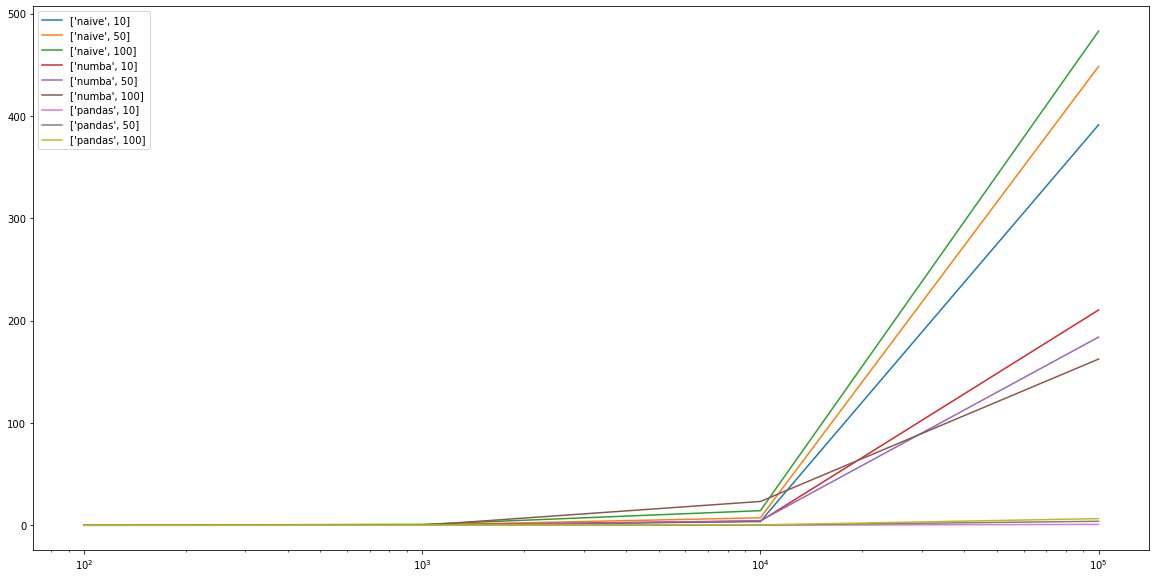

In [34]:
plt.figure(figsize=(20, 10))

for i, func in enumerate(list_functions):
    for k in list_K:
        time_list = []
        
        for n in list_users_count:
            sample, users, recs = generate_subsample(interactions, n, k)
            start = time.time()
            
            if list_functions[func] == mrr_pandas:
                list_functions[func](sample, users, recs, k)
            else:
                list_functions[func](sample.values, users, recs, k)
                
            time_list.append(time.time() - start)
            
        plt.plot(list_users_count, time_list, label=[func, k])
        plt.legend()
        plt.xscale('log')